In [17]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re
data = pd.read_csv('merged_conversations.csv',encoding='utf-8-sig')
data

,SourceType,SourceURL,SourceAuthor,SourceTitle,Prompt,Answer,ListOfCode,ChatgptURL,DateOfConversation,Model,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers
0,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,"Hey, I am working on writing a technical docum...","Of course, I'd be happy to help you translate ...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
1,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,I noticed that I've already have translated co...,"Absolutely, I'd be glad to help you refine the...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
2,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,# Working Principle of dae\n\n[**简体中文**](../zh...,Working Principle of dae简体中文 | Englishdae oper...,[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
3,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,Is the gramma refined?,"Yes, the grammar has been refined in the provi...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
4,pull request,https://github.com/FlorianWoelki/obsidian-symb...,sharshuv-quotient,Fix constructor being converted to undefined,I have this code:\n\nconst characterMap: Chara...,This issue arises because object property look...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",https://chat.openai.com/share/acece149-6d4b-45...,"August 23, 2023",Default,2,223,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18753,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Let's work this out in a step-by-step way to b...,"Sure, we can use a similar approach to the one...",[],https://chat.openai.com/share/62a8cdf2-6de6-49...,"May 27, 2023",Default,2,91,528
18754,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Who is Obie Fernandez and what is he famous for?,Obie Fernandez is a well-known figure in the f...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18755,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Sure go ahead. I'm interested in his other pur...,Obie Fernandez is a Ruby and Ruby on Rails dev...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18756,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,"What is Hacker News, what can you tell me abou...",Hacker News is a social news website focusing ...,[],https://chat.openai.com/share/66169853-d00a-4b...,"May 27, 2023",Default,1,17,390


In [18]:
#data['ListOfCode'].value_counts()
import ast
def extract_types(list_of_code):
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return[item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedTypes'].value_counts()

ExtractedTypes
[]                          11517
[python]                      795
[javascript]                  609
[sh]                          608
[bash]                        282
                            ...  
[yaml, bash, yaml, bash]        1
[yaml, txt, yaml]               1
[css, yaml, txt, yaml]          1
[sh, sql, swift]                1
[go, swift]                     1
Name: count, Length: 802, dtype: int64

<Axes: >

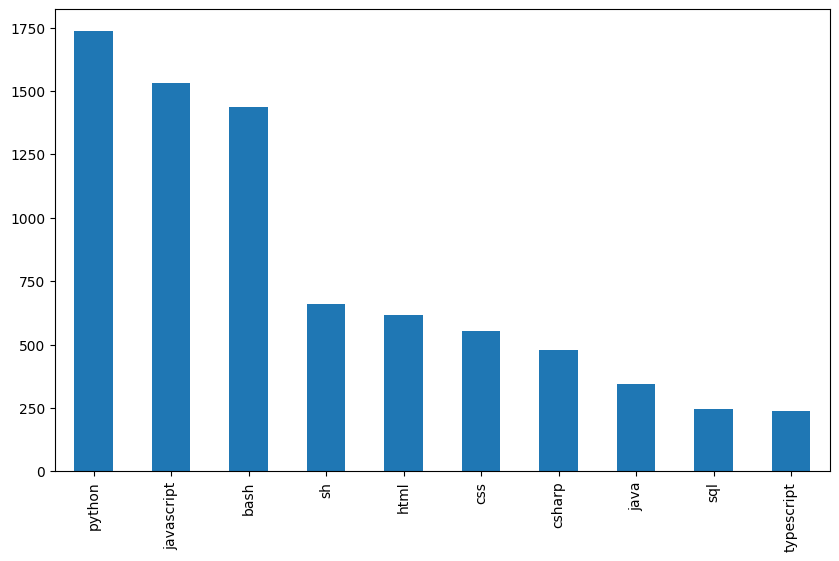

In [19]:
from collections import Counter
from itertools import chain
type_counts = Counter(chain.from_iterable(data["ExtractedTypes"]))
type_counts_series = pd.Series(type_counts)
type_counts_series.sort_values(ascending=False)[:10].plot(kind='bar', figsize=(10,6))

In [21]:
# Function to extract types
def extract_types(list_of_code):
    """
    Extract the 'Type' fields from a list of code objects.

    Parameters:
    list_of_code (str): A string representation of a list of dictionaries, where each dictionary represents a code snippet and may contain a 'Type' key.

    Returns:
    list: A list of 'Type' values extracted from the input. If the input is NaN or an empty list ('[]'), an empty list is returned.
    """
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return [item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

# Extract types and filter for Python snippets
data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedContent'] = data["ListOfCode"].apply(lambda x: [
    item.get('Content') for item in ast.literal_eval(x) 
    if 'Type' in item and item['Type'] == 'sql'
])

# Flatten and find unique Python snippets
all_sql_contents = list(chain.from_iterable(data['ExtractedContent']))
unique_sql_contents = list(set(all_sql_contents))

In [31]:
import sqlite3

def simulate_sql_execution(sql_code):
    """
    Simulate the execution of an SQL statement using an in-memory SQLite database.

    Parameters:
    sql_code (str): A string containing the SQL statement to execute.

    Returns:
    str or None: Returns a specific error message if an error occurs during execution, such as:
        - "table does not exist": If the referenced table does not exist.
        - "Syntax error": If there is a syntax error in the SQL statement.
        - "unrecognized token": If an unrecognized token is found in the SQL.
        - Any other error message as a string.
        - None if the SQL executes without errors.
    """
    try:
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        cursor = conn.cursor()
        # Execute SQL code (ensure it's safe to run, e.g., no injections)
        cursor.execute(sql_code)
        conn.commit()  # Commit if it's a DML statement
        conn.close()
        return None  # No error
    except sqlite3.OperationalError as e:
        # Check if the error message contains 'no such table'
        if "no such table" in str(e).lower():
            return "table does not exist"
        elif "syntax" in str(e).lower():
            return "Syntax error" 
        elif "unrecognized token":
            return "unrecognized token"
        else:
            return str(e)
    except Exception as e:
        return str(e)  # Return any other general errors


In [33]:
# Map each SQL code to its error (if any)
error_mapping = {}
for sql_code in unique_sql_contents:
    error_message = simulate_sql_execution(sql_code)
    if error_message:
        error_mapping[sql_code] = error_message
    else:
        error_mapping[sql_code] = 'No error'


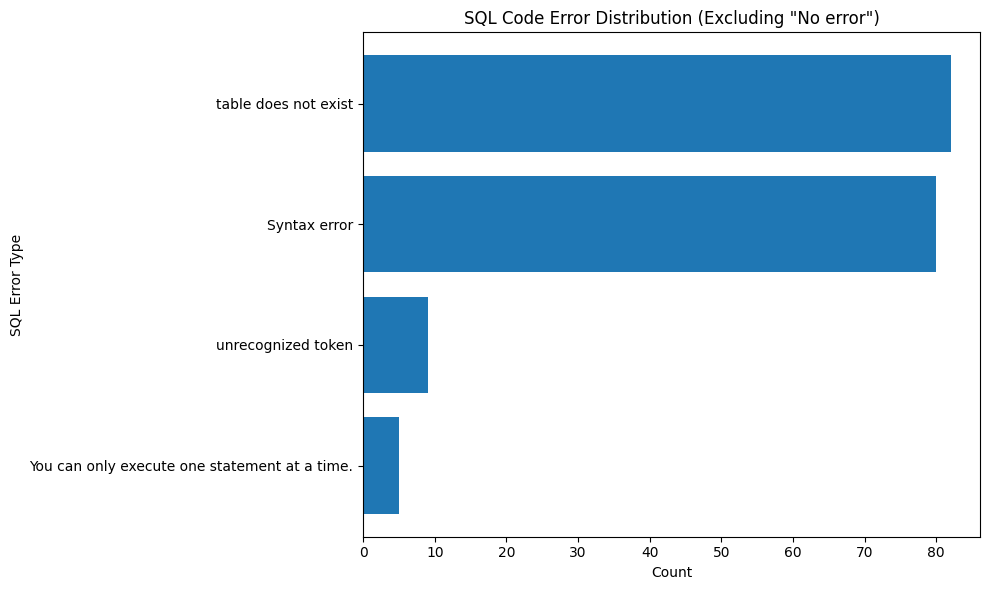

In [35]:
filtered_errors = {sql: error for sql, error in error_mapping.items() if error != 'No error'}

# Count the frequency of each error
error_counts = {}
for error in filtered_errors.values():
    error_counts[error] = error_counts.get(error, 0) + 1

# Plotting the errors (Horizontal bar plot)
plt.figure(figsize=(10, 6))

# Convert dict_keys to lists for the bar plot
plt.barh(list(error_counts.keys()), list(error_counts.values()))
plt.gca().invert_yaxis()  # Invert y-axis for better visual
plt.xlabel('Count')
plt.ylabel('SQL Error Type')
plt.title('SQL Code Error Distribution (Excluding "No error")')
plt.tight_layout()
plt.show()